# Project 3. Booking Reviews

<center> <img src = https://storage.googleapis.com/kaggle-competitions/kaggle/34288/logos/header.png alt="drawing">

---

## 0. Prerequisites

### The libraries

In [41]:
import pandas as pd
import numpy as np
from collections import Counter
from category_encoders import TargetEncoder
from sklearn import preprocessing
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/dkudr/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### The constants

In [42]:
# INPUT_DIR = '../input/sf-booking/'
INPUT_DIR = './data/'
RANDOM_SEED = 42  # The Ultimate Answer of life, the Universe, and everything
TARGET = 'reviewer_score'

### The data

In [43]:
train = pd.read_csv(INPUT_DIR + 'hotels_train.csv')
test = pd.read_csv(INPUT_DIR + 'hotels_test.csv')
submission = pd.read_csv(INPUT_DIR + 'submission.csv')
# Countries' population: https://www.kaggle.com/datasets/tanuprabhu/population-by-country-2020
# population = pd.read_csv(
#     '../input/population-by-country-2020/population_by_country_2020.csv')
population = pd.read_csv(INPUT_DIR + 'population_by_country_2020.csv')

---

## 1. Data preprocessing

### 1.1. Initial cleansing

In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

**A standard report made with the Pandas Profiling library was used to evaluate initial distributions and general patameters of the features.**

In [45]:
dupl_percent = train.duplicated().mean() * 100
print(f'Duplicated rows in the train sample: {dupl_percent:.2f}%')
train.drop_duplicates(inplace=True)
print('Duplicates dropped')

Duplicated rows in the train sample: 0.08%
Duplicates dropped


In [46]:
print('The number of blanks in the object-type columns')
for col in train.dtypes[train.dtypes=='object'].index:
    print(col+':', train[train[col] == ' '].shape[0])

The number of blanks in the object-type columns
hotel_address: 0
review_date: 0
hotel_name: 0
reviewer_nationality: 395
negative_review: 606
positive_review: 128
tags: 0
days_since_review: 0


In [47]:
# Here we fill in the blanks in the 'reviewer_nationality' column with the 
# mode value. The 'negative_review' and 'positive_review' columns as well 
# as 'lat and 'lng' columns with NaN values are to be processed later.

train['reviewer_nationality'] = train['reviewer_nationality'].apply(
    lambda x: x[1:-1])  # Removing the spaces around: ' Spain ' -> 'Spain'
test['reviewer_nationality'] = test['reviewer_nationality'].apply(
    lambda x: x[1:-1]) 

replace_dict = {'': train['reviewer_nationality'].mode()[0]}
train['reviewer_nationality'].replace(replace_dict, inplace=True)
test['reviewer_nationality'].replace(replace_dict, inplace=True)

### 1.2. Feature engineering

**Some columns has high cardinality. We will use the Target Encoder to represent such features. As the encoder needs to know the exact target values ('reviewer_score'), we have to process this features before combining the train and test datasets, i.e., separately for the test and train data.**

In [48]:
# Extracting country names and zip codes from hotel addresses. There is only 
# one city per a country in the addresses, so we omit city name extraction as 
# this will not give any new information for the ML algorithms, and in this 
# particular case "city == country". The zip code, on the other hand, contains 
# information about the hotel location within a city, which might be very 
# useful for rating evaluation

def address_proc(x):
    words = x.split()
    country = words[-1]
    if country=='Kingdom' or country=='Netherlands':
        zip_code = words[-4] + words[-3]
    else:
        zip_code = words[-3]
    return pd.Series([country, zip_code])


train[['hotel_country', 'zip_code']] = train['hotel_address'].apply(address_proc)
train['hotel_country'].replace({'Kingdom': 'United Kingdom'}, inplace=True)

test[['hotel_country', 'zip_code']] = test['hotel_address'].apply(address_proc)
test['hotel_country'].replace({'Kingdom': 'United Kingdom'}, inplace=True)

print('The countries:', train['hotel_country'].unique())
print('The number of zip codes (city districts):', train['zip_code'].nunique())

The countries: ['United Kingdom' 'France' 'Netherlands' 'Italy' 'Austria' 'Spain']
The number of zip codes (city districts): 601


In [49]:
# Encoding the columns with high cardinality using the Target Encoder

cols = ['hotel_name', 'reviewer_nationality', 'zip_code']
target_encoder = TargetEncoder(cols=cols)
train_encoded = target_encoder.fit_transform(
    train[cols], train[TARGET])
test_encoded = target_encoder.transform(test[cols])

rename_dict = {
    'hotel_name': 'hotel_name_enc', 
    'reviewer_nationality': 'reviewer_nationality_enc', 
    'zip_code': 'zip_code_enc'
}
train_encoded.rename(columns=rename_dict, inplace=True)
test_encoded.rename(columns=rename_dict, inplace=True)

train = pd.concat([train, train_encoded], axis=1)
test = pd.concat([test, test_encoded], axis=1)

In [50]:
# Checking for NaNs in the encoded test features

print(test['hotel_name_enc'].isnull().mean())
print(test['reviewer_nationality_enc'].isnull().mean())
print(test['zip_code_enc'].isnull().mean())

0.0
0.0
0.0


In [51]:
# Combining the train and test datasets for further mutual data processing

train['is_train'] = True
test['is_train'] = False
test[TARGET] = 0
data = pd.concat([train, test])

In [52]:
# Domestic customer: the reiewer's nationality and the hotel country are 
# the same.

data['domestic_customer'] = data.apply(lambda x:
    1 if x['hotel_country'] == x['reviewer_nationality'] else 0, axis=1)    

In [53]:
# Extracting some information from the review date.
#
# Day of the year is encoded to sines and cosines to reflect the cyclic 
# process. Simultaneously with the calendar date numerical description, this 
# allows us to encode the season changing in a more precise way than the common 
# 4-season division. The Christmas and weekend indicators are additionally 
# included.

data['review_date'] = pd.to_datetime(data['review_date'])

data['sin_date'] = np.sin(2 * np.pi * data['review_date'].dt.dayofyear / 365)
data['cos_date'] = np.cos(2 * np.pi * data['review_date'].dt.dayofyear / 365)

data['christmas'] = data['review_date'].apply(lambda x: 
    1 if (x.month==12 and x.day>=25) or (x.month==1 and x.day<=5) else 0)
data['weekend'] = data['review_date'].apply(lambda x: 
    1 if x.dayofweek==5 or x.dayofweek==6 else 0)

In [54]:
# Adding reviewer's country population from 
# https://www.kaggle.com/datasets/tanuprabhu/population-by-country-2020

# Mathicng some names in the datasets
replace_dict = {
    'Czech Republic (Czechia)': 'Czech Republic',
    'United States': 'United States of America'
}
population['Country (or dependency)'].replace(replace_dict, inplace=True)

# Left merging of population to our dataset: row order is intact
df_to_merge = population[['Country (or dependency)', 'Population (2020)']]
data = data.merge(df_to_merge, how='left', left_on='reviewer_nationality',
                  right_on='Country (or dependency)')

# Setting the population of the minor territories (NaN values of population)
#  to the minimum
data['Population (2020)'].fillna(data['Population (2020)'].min(), inplace=True)
data.rename(columns={'Population (2020)': 'reviewer_country_population'}, 
            inplace=True)
data.drop(['Country (or dependency)'], axis=1, inplace=True)

In [55]:
# Sentiment analysis
#
# First, we make empty strings for various designations of empty reviews, 
# then analyze the negative and positive reviews separately using the VADER 
# sentiment analysis and taking the 'compound' value as a result.

replace_dict_negative = {
    'No Negative': '',
    ' Nothing ': '',
    ' Nothing': '',
    ' nothing ': '',
    ' nothing': '',
    ' N A ': '',
    ' N A': '',
    ' N a ': '',
    ' N a': '',
    ' None ': '',
    ' None': '',
    ' ': ''   
}

replace_dict_positive = {
    'No Positive': '',
    ' Nothing ': '',
    ' Nothing': '',
    ' nothing ': '',
    ' nothing': '',
    ' N A ': '',
    ' N A': '',
    ' N a ': '',
    ' N a': '',
    ' None ': '',
    ' None': '',
    ' ': ''   
}

data['negative_review'].replace(replace_dict_negative, inplace=True)
data['positive_review'].replace(replace_dict_positive, inplace=True)

mask = data['negative_review'] == ''
data.loc[mask, 'review_total_negative_word_counts'] = 0

mask = data['positive_review'] == ''
data.loc[mask, 'review_total_positive_word_counts'] = 0

analyzer = SentimentIntensityAnalyzer()
data['n_sentiment'] = data['negative_review'].apply(lambda x: 
    analyzer.polarity_scores(x)['compound'])
data['p_sentiment'] = data['positive_review'].apply(lambda x: 
    analyzer.polarity_scores(x)['compound'])

In [56]:
# Tags. Converting string variables to lists.

data['tags'] = data['tags'].apply(lambda x: x[3:-3].split(' \', \' '))

In [57]:
# Getting stay duration. 
# Filling in NaN values with the typical stay duration: 1 day.

def get_stay(x):
    for tag in x:
        words = tag.split()
        if words[0] =='Stayed':
            return int(words[1])
    return np.NaN

data['stay'] = data['tags'].apply(get_stay)
data['stay'].fillna(1, inplace=True)

In [58]:
# Starting one-hot encoding for the most frequent tags. The boundary for the 
# most frequent is taken as 5% of the dataset size.

boundary = data.shape[0] * 0.05  # 5% boundary
c = Counter(tag for row in data['tags'] for tag in row)
frequent_tags_count = dict(filter(lambda x: x[1] > boundary, c.items()))
print('Most frequent tags and their counts:')
frequent_tags_count

Most frequent tags and their counts:


{'Leisure trip': 417538,
 'Couple': 252128,
 'Stayed 2 nights': 133850,
 'Submitted from a mobile device': 307470,
 'Business trip': 82884,
 'Standard Double Room': 32247,
 'Stayed 1 night': 193568,
 'Solo traveler': 108476,
 'Stayed 3 nights': 95761,
 'Superior Double Room': 31361,
 'Stayed 4 nights': 47777,
 'Double Room': 35207,
 'Family with young children': 60989,
 'Group': 65361,
 'Family with older children': 26334}

In [59]:
# Getting the list of the most frequent tags. The "stay" tags are excluded

frequent_tags = list(dict(filter(lambda x: 
    x[1]>boundary and x[0].split()[0]!='Stayed', 
    frequent_tags_count.items())).keys())
frequent_tags

['Leisure trip',
 'Couple',
 'Submitted from a mobile device',
 'Business trip',
 'Standard Double Room',
 'Solo traveler',
 'Superior Double Room',
 'Double Room',
 'Family with young children',
 'Group',
 'Family with older children']

In [60]:
# One-hot encoding for frequent tags.

for tag in frequent_tags:
    data[tag] = data['tags'].apply(lambda x: 1 if tag in x else 0)

In [61]:
# Converting the 'days_since_review' feature to the chronological order of the 
# review dates: from day 0 to the last day.

data['days_since_review'] \
    = data['days_since_review'].apply(lambda x: int(x.split()[0]))
data['day_number'] \
    = (data['days_since_review']-data['days_since_review'].max()) * (-1)

In [62]:
# Fillling in the NaN values of latitude and longitude with the median values 
# for each zip code (city district).

# Data frame with median values:
zip_medians = data.groupby('zip_code')[['lat', 'lng']].median()

mask1 = data['lat'].isnull()
zip_nulls = data[mask]['zip_code'].unique()  # zip codes having NaN lat and lng
for zip_code in zip_nulls:
    mask2 = data['zip_code'] == zip_code
    data.loc[mask1 & mask2, 'lat'] = zip_medians.loc[zip_code, 'lat']
    data.loc[mask1 & mask2, 'lng'] = zip_medians.loc[zip_code, 'lng']

In [63]:
print('Fraction of NaNs remained')
print('lat:', data['lat'].isnull().mean())
print('lng:', data['lng'].isnull().mean())

Fraction of NaNs remained
lat: 0.0
lng: 0.0


In [64]:
# Getting distances from the city center

for country in data['hotel_country'].unique():
    
    mask = data['hotel_country']==country
    
    # City centers as the median values for a country (=city)
    lat_median = data[mask]['lat'].median()
    lng_median = data[mask]['lng'].median()
    
    data.loc[mask, 'distance'] = ((data[mask]['lat']-lat_median)**2
                                  +(data[mask]['lng']-lng_median)**2) ** (1/2)
    

In [65]:
# One-hot encoding for hotels' countries/cities.

country_onehot = pd.get_dummies(data['hotel_country'])
data = pd.concat([data, country_onehot], axis=1)

In [66]:
# Dropping processed columns

data.drop(['hotel_address', 'review_date', 'hotel_name', 'zip_code',
           'reviewer_nationality', 'negative_review', 'positive_review',
           'tags', 'days_since_review', 'lat', 'lng', 'hotel_country'], 
          axis=1, inplace=True)

### 1.3. Multicollinearity

In [67]:
def get_correlated(corr_matrix, thres=0.7):
    """Getting correlated pairs from a correlation matrix 
       with correlation coefficients higher than the threshold

    Args:
        corr_matrix (pandas DataFrame): correlation matrix (e.g., from df.corr())
        thres (float, optional): threshold. Defaults to 0.7 (i.e., coeff > 0.7 or coeff < -0.7).

    Returns:
        pandas Series: correlated pairs and correlation coefficients
    """
    
    correlated_pairs = {}
    
    for col in corr_matrix.columns:
        positive_filter = corr_matrix[col] >= thres
        negative_filter = corr_matrix[col] <= -thres
        match_series = corr_matrix[col][positive_filter | negative_filter]
        for match in match_series.index:
            if match != col and match + ' -- ' + col not in correlated_pairs.keys():
                correlated_pairs.update({col + ' -- ' + match: match_series[match]})
   
    return pd.Series(correlated_pairs).sort_values()


print('Correlated pairs:')
get_correlated(data.corr(method='spearman'))

Correlated pairs:


Leisure trip -- Business trip                             -0.904047
review_total_positive_word_counts -- p_sentiment           0.725829
reviewer_score -- is_train                                 0.758933
average_score -- zip_code_enc                              0.839766
hotel_name_enc -- zip_code_enc                             0.849969
additional_number_of_scoring -- total_number_of_reviews    0.859098
average_score -- hotel_name_enc                            0.977408
dtype: float64

In [68]:
# Dropping matches with strong correlation. We will stay the 
# "review_total_positive_word_counts - p_sentiment" pair , as the correlation
# is not that strong and leaving both features improves the MAPE a little

data.drop([
    'Business trip', 'additional_number_of_scoring', 
    'hotel_name_enc', 'zip_code_enc'], 
    axis=1, inplace=True)

### 1.4. Normalization

In [69]:
# After analyzing the distributions (with the Pandas df.hist() method), 
# the following scalers have been chosen:
# 
# MinMaxScaler - for 'average_score', 'day_number'
#
# RobustScaler - for 'review_total_negative_word_counts', 
# 'review_total_positive_word_counts', 'total_number_of_reviews', 
# 'total_number_of_reviews_reviewer_has_given', 
# 'reviewer_country_population'
#
# Other columns - without normalization

cols_minmax = ['average_score', 'day_number']
cols_robust = [
    'review_total_negative_word_counts', 'review_total_positive_word_counts',
    'total_number_of_reviews', 'total_number_of_reviews_reviewer_has_given',
    'reviewer_country_population']

mm_scaler = preprocessing.MinMaxScaler()
r_scaler = preprocessing.RobustScaler()

data_mm = mm_scaler.fit_transform(data[cols_minmax])
data_mm = pd.DataFrame(data_mm, columns=cols_minmax)

data_rs = r_scaler.fit_transform(data[cols_robust])
data_rs = pd.DataFrame(data_rs, columns=cols_robust)

data[cols_minmax] = data_mm[cols_minmax]
data[cols_robust] = data_rs[cols_robust]

### 1.5. Feature selection

In [70]:
# Separating the train and test datasets after processing

train = data[data['is_train']]
test = data[data['is_train'] == False]

train = train.copy()
test = test.copy()
train.drop(['is_train'], axis=1, inplace=True)
test.drop(['is_train', TARGET], axis=1, inplace=True)

In [71]:
# X are the features, y is the target

X = train.drop([TARGET], axis = 1)  
y = train[TARGET]

In [72]:
# Category and continuous features

cat_cols = [
    'domestic_customer', 'christmas', 'weekend', 'Leisure trip', 'Couple', 
    'Submitted from a mobile device', 'Standard Double Room', 'Solo traveler', 
    'Superior Double Room', 'Double Room', 'Family with young children', 
    'Group', 'Family with older children', 'Austria', 'France', 'Italy',
    'Netherlands', 'Spain', 'United Kingdom', 'stay']

cont_cols = [
    'average_score', 'review_total_negative_word_counts', 'distance',
    'total_number_of_reviews', 'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given', 'reviewer_nationality_enc', 
    'sin_date', 'cos_date', 'reviewer_country_population', 'n_sentiment', 
    'p_sentiment', 'day_number']

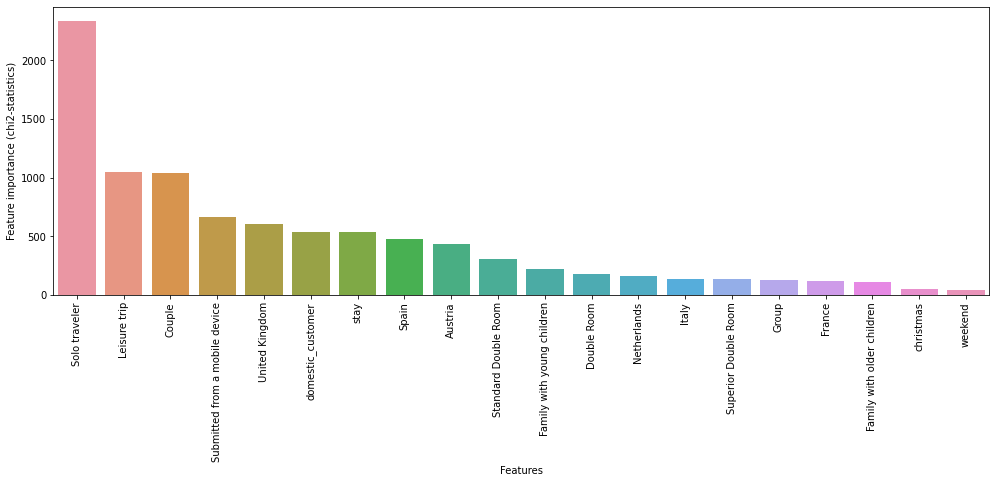

In [73]:
# Calculating chi2-statistics for the category features

y_cat = (y * 10).astype('int')  # class cannot be float for chi2

chi2_stat, chi2_p = chi2(X[cat_cols], y_cat)
chi2_stat = pd.DataFrame(chi2_stat, index=cat_cols).reset_index()
chi2_stat.rename(
    columns={'index': 'Features', 0: 'Feature importance (chi2-statistics)'}, 
    inplace=True)
chi2_stat['p-value'] = chi2_p
chi2_stat.sort_values('Feature importance (chi2-statistics)', 
                   inplace = True, ascending=False)

fig = plt.figure(figsize=(13, 4))
ax = fig.add_axes([1, 1, 1, 1])
plt.xticks(rotation=90)
sns.barplot(data=chi2_stat, x='Features', y='Feature importance (chi2-statistics)');

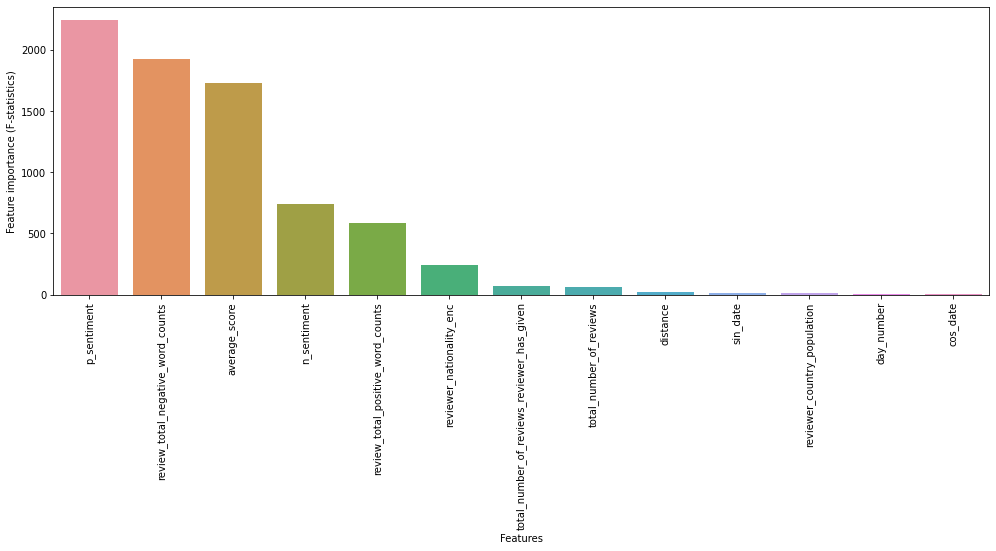

In [74]:
# Calculating F-statistics (ANOVA) for the category features

f_stat, f_p = f_classif(X[cont_cols], y)
f_stat = pd.DataFrame(f_stat, index=cont_cols).reset_index()
f_stat.rename(
    columns={'index': 'Features', 0: 'Feature importance (F-statistics)'}, 
    inplace=True)
f_stat['p-value'] = f_p
f_stat.sort_values('Feature importance (F-statistics)', 
                   inplace = True, ascending=False)

fig = plt.figure(figsize=(13, 4))
ax = fig.add_axes([1, 1, 1, 1])
plt.xticks(rotation=90)
sns.barplot(data=f_stat, x='Features', y='Feature importance (F-statistics)');

In [75]:
# Additionaly, let's check the significance using the p-value

mask = chi2_stat['p-value'] > 0.05  # 5% boundary
print('The insignificant category features:', 
      list(chi2_stat[mask]['Features']))

mask = f_stat['p-value'] > 0.05  # 5% boundary
print('The insignificant continuous features:', 
      list(f_stat[mask]['Features']))

The insignificant category features: ['weekend']
The insignificant continuous features: []


In [76]:
# Dropping insignificant features

drop_cols = ['weekend']
X.drop(drop_cols, axis=1, inplace = True)
test.drop(drop_cols, axis=1, inplace = True)

## 3. Random Forest regression

In [77]:
# X_train, y_train - training dataset
#
# X_test, y_test - evaluation dataset

X_train, X_test, y_train, y_test \
    = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)
    
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1,
                             random_state=RANDOM_SEED)  
regr.fit(X_train, y_train)  

y_pred = regr.predict(X_test)
y_pred = y_pred.round(1)
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s


MAPE: 0.12448862801331592


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.6s finished


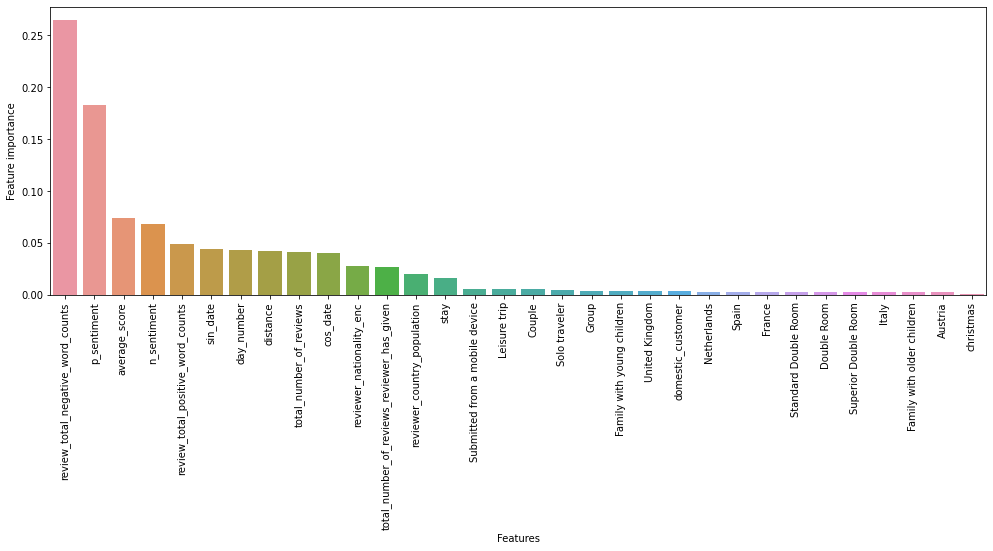

In [78]:
# Feature importances from Forest Regressor

feat_importances = pd.DataFrame(regr.feature_importances_, 
                                index=X.columns).reset_index()
feat_importances.rename(
    columns={'index': 'Features', 0: 'Feature importance'}, 
    inplace=True)
feat_importances.sort_values('Feature importance', 
                   inplace = True, ascending=False)

fig = plt.figure(figsize=(13, 4))
ax = fig.add_axes([1, 1, 1, 1])
plt.xticks(rotation=90)
sns.barplot(data=feat_importances, x='Features', y='Feature importance');

In [79]:
# Kaggle submission prediction

submission_predict = regr.predict(test)
submission_predict = submission_predict.round(1)
submission[TARGET] = submission_predict
submission.to_csv('submission_result.csv', index=False)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.9s finished


In [80]:
submission

,reviewer_score,id
0,8.8,488440
1,7.3,274649
2,8.2,374688
3,9.5,404352
4,9.6,451596
...,...,...
128930,8.9,495812
128931,9.4,315577
128932,7.8,511968
128933,9.4,303386
